In [1]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

In [2]:
data_path = "Portraits"
batch_s = 64
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 1000 files belonging to 1 classes.


In [3]:
latent_dim = 100
g_resolution=2

generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0

(-0.5, 63.5, 63.5, -0.5)

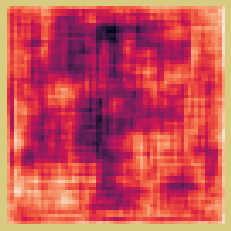

In [4]:
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False) 
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

In [5]:
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

In [6]:
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.4999984]], shape=(1, 1), dtype=float32)


In [7]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(seed)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [8]:
epochs = 100
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()

model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

history = model.fit(data, epochs=epochs)

Epoch 1/100
16/16 [==============================] - 127s 8s/step - d_loss: 0.6485 - g_loss: 0.6770
Epoch 2/100
16/16 [==============================] - 128s 8s/step - d_loss: 0.4109 - g_loss: 0.7234
Epoch 3/100
16/16 [==============================] - 125s 8s/step - d_loss: 0.3860 - g_loss: 0.7586
Epoch 4/100
16/16 [==============================] - 126s 8s/step - d_loss: 0.3691 - g_loss: 0.7907
Epoch 5/100
16/16 [==============================] - 126s 8s/step - d_loss: 0.3497 - g_loss: 0.8349
Epoch 6/100
16/16 [==============================] - 125s 8s/step - d_loss: 0.3257 - g_loss: 0.8986
Epoch 7/100
16/16 [==============================] - 124s 8s/step - d_loss: 0.3002 - g_loss: 0.9703
Epoch 8/100
16/16 [==============================] - 124s 8s/step - d_loss: 0.2680 - g_loss: 1.0769
Epoch 9/100
16/16 [==============================] - 124s 8s/step - d_loss: 0.2336 - g_loss: 1.2185
Epoch 10/100
16/16 [==============================] - 128s 8s/step - d_loss: 0.1944 - g_loss: 1.4114

16/16 [==============================] - 143s 9s/step - d_loss: -2549.2668 - g_loss: 233313.0156
Epoch 80/100
16/16 [==============================] - 143s 9s/step - d_loss: -3006.2214 - g_loss: 279488.1250
Epoch 81/100
16/16 [==============================] - 144s 9s/step - d_loss: -3474.2659 - g_loss: 336068.1250
Epoch 82/100
16/16 [==============================] - 146s 9s/step - d_loss: -4440.2412 - g_loss: 405660.6250
Epoch 83/100
16/16 [==============================] - 143s 9s/step - d_loss: -5561.3223 - g_loss: 495310.1250
Epoch 84/100
16/16 [==============================] - 141s 9s/step - d_loss: -6737.6299 - g_loss: 605654.5625
Epoch 85/100
16/16 [==============================] - 125s 8s/step - d_loss: -8032.3271 - g_loss: 729452.0625
Epoch 86/100
16/16 [==============================] - 127s 8s/step - d_loss: -9417.9785 - g_loss: 874891.3750
Epoch 87/100
16/16 [==============================] - 131s 8s/step - d_loss: -11346.3926 - g_loss: 1028134.7500
Epoch 88/100
16/16 [=

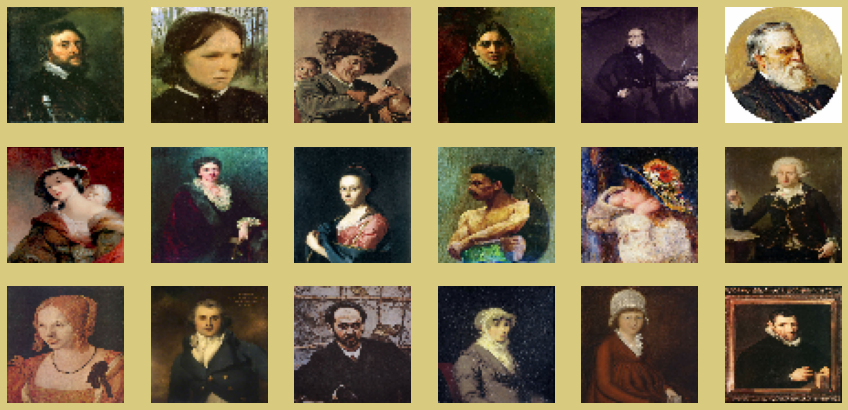

In [10]:
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
            
Show_Img(data)